# Processing X-ray tomography data

- FF-correction
- Stitching

In [31]:
import numpy as np
from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile
import matplotlib.pyplot as plt
import os

In [32]:
#folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/144mm/'

In [33]:
#create the list all images in the folder
imlist = os.listdir(folder)

# FF-correct

- Script to FF-correct multiple images in one go
- Includes function that requires the lists of data-images and ff-images

In [34]:
#function for ff-correction for one distance and one section
def find_paths_single_distance(data_list, key):
    return [i for i in data_list if i.startswith(key)]

In [35]:
#define lists of data and ff-images for correction
image_data = find_paths_single_distance(imlist, 'try0_full_144mm_3_')
ff_data = find_paths_single_distance(imlist, 'ff_try0_full_144mm_3_')
image_data.sort(), ff_data.sort()

(None, None)

In [36]:
def ff_correct_list(image_data, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes several data images and ff corrects it
    
    image_data: list
        paths to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = np.asarray([tifffile.imread(folder+im) for im in image_data])
    images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    ff_class = SSIM.SSIM_const(flatfield)

    # a list to store results
    result = []

    for count,item in enumerate(images):
        image_class = SSIM.SSIM_const(item)
        index = SSIM.SSIM(image_class, ff_class).ssim()
        result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
        print('processed image ', image_data[count])
        
    return result

In [37]:
#run function for x number of images
image_correct = ff_correct_list(image_data[:],ff_data, ROI=(0,0,2048,2048))

<ipython-input-36-507096e41889>:35: RuntimeWarning: divide by zero encountered in true_divide
  result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
<ipython-input-36-507096e41889>:35: RuntimeWarning: invalid value encountered in true_divide
  result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))


processed image  try0_full_144mm_3_00001.tiff
processed image  try0_full_144mm_3_00002.tiff
processed image  try0_full_144mm_3_00003.tiff
processed image  try0_full_144mm_3_00004.tiff
processed image  try0_full_144mm_3_00005.tiff
processed image  try0_full_144mm_3_00006.tiff
processed image  try0_full_144mm_3_00007.tiff
processed image  try0_full_144mm_3_00008.tiff
processed image  try0_full_144mm_3_00009.tiff
processed image  try0_full_144mm_3_00010.tiff


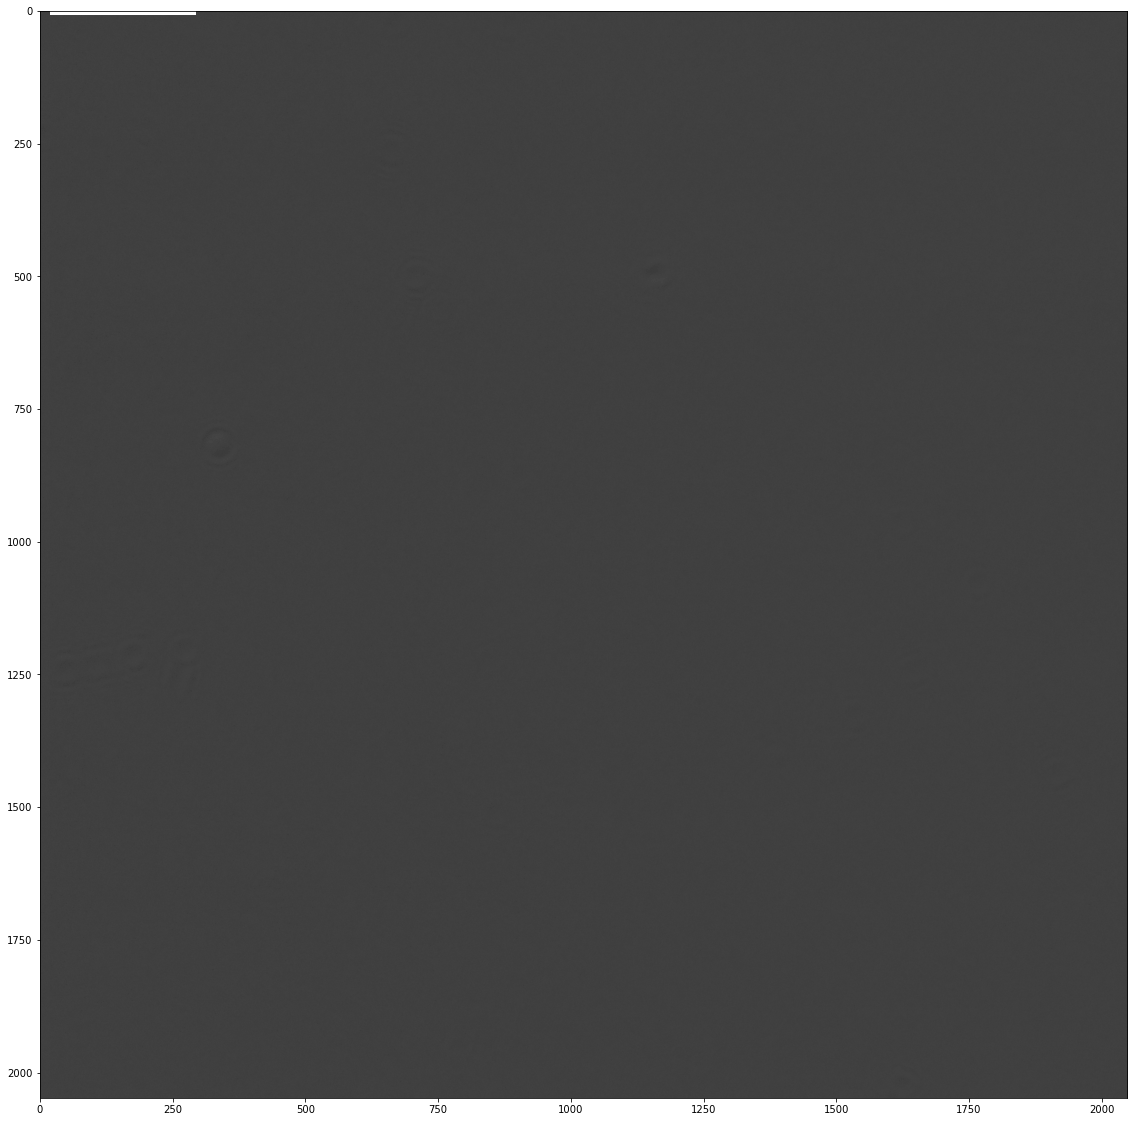

In [38]:
# filtered image
var.show(image_correct[9])

# Stitching

- Script to sticth multiple images into one slice

In [39]:
# select just one distance and one acquisition
def find_paths_single_distance_all(data_list, key, distance, image):
    return [i for i in data_list if (i.startswith(key) and distance in i and image in i)]

In [40]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = '144mm', image = '0001.tiff')
data_test = sorted(data_test, key=lambda i: int(find_counter(i)))
data_test

['try0_full_144mm_1_00001.tiff',
 'try0_full_144mm_2_00001.tiff',
 'try0_full_144mm_3_00001.tiff']

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

# Tried stitching original images using these basic functions from Image library

Problems:
- I don't know the image mode of our data
- We need to be able to stitch horizontally batchs of consecutive 17 images (combined filled of view is 17 columns by 7 rows). Then we can stitch vertically batchs of 7 images.
- We probably need to remove some pixels due to image overlapping - 83 um - 510 pixels
- Can you use this as a basis for a function?
- Instead of using the original images, the idea as to be to use the processed images that we get from ff-correction

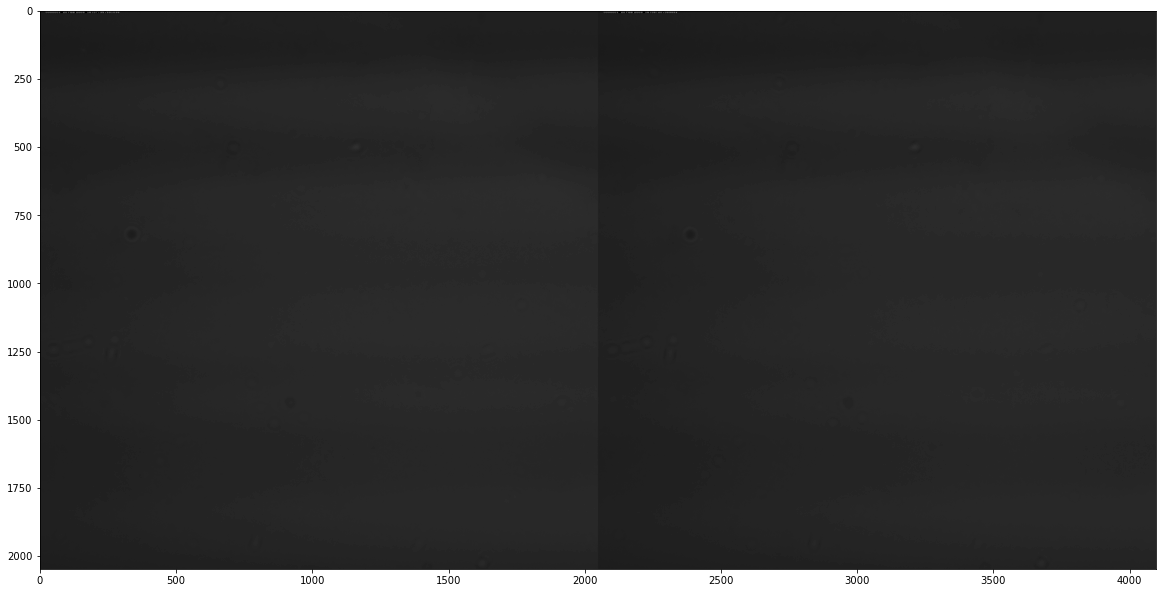

In [53]:
#stitch images horizontally first
#open images
img1 = Image.open(folder+'try0_full_144mm_1_00001.tiff')
img2 = Image.open(folder+'try0_full_144mm_2_00001.tiff')
#resize images to crop overlapping region
img1_resize = img1.resize((2048,2048))
img2_resize = img2.resize((2048,2048))
#create new image
img_final = Image.new('I;16', (4096,2048),"white")
img_final.paste(img1_resize,(0,0))
img_final.paste(img2_resize,(2048,0))
var.show(img_final)